In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import os
import math
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display

In [4]:
#Defining path to our image source.
root_dir = "/content/drive/MyDrive/Colab Notebooks/images"

We create training and validation datasets via `image_dataset_from_directory`.

In [5]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 600 files belonging to 1 classes.
Using 480 files for training.
Found 600 files belonging to 1 classes.
Using 120 files for validation.


We rescale the images to take values in the range [0, 1].

In [6]:
#Defining the image rescaling function and rescaling 256bit to 0:1 range
def scaling(input):
    input = input / 255.0
    return input

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

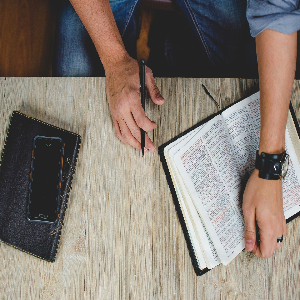

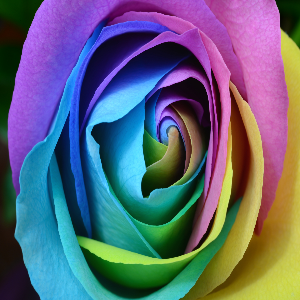

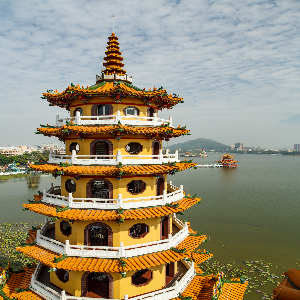

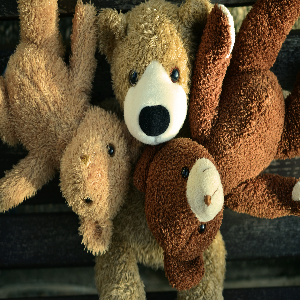

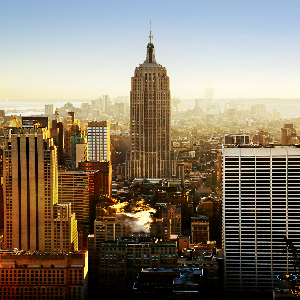

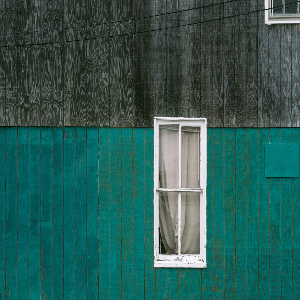

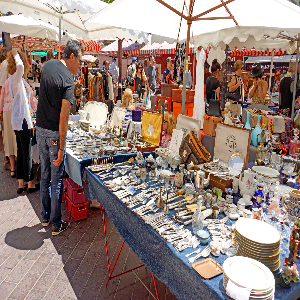

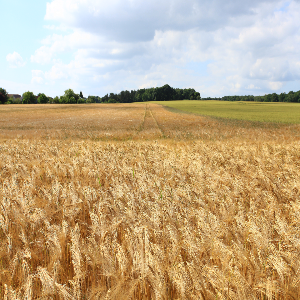

In [7]:
#Visualizing a few images
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [8]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)

In [9]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [10]:
#defining the model function. Doing it this way gives us flexibility in training different images with different resolutions.
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [12]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [13]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

## Train the model

Epoch 1/300
60/60 - 926s - loss: 0.5305 - SSIMLoss: 0.5305 - val_loss: 0.4185 - val_SSIMLoss: 0.4185
Mean PSNR for epoch: 3.89


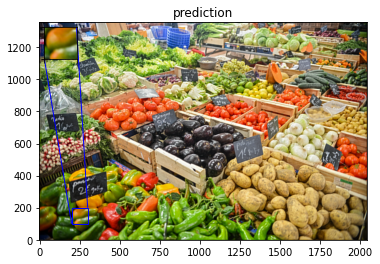

Epoch 2/300
60/60 - 869s - loss: 0.3858 - SSIMLoss: 0.3858 - val_loss: 0.3658 - val_SSIMLoss: 0.3658
Mean PSNR for epoch: 4.33
Epoch 3/300
60/60 - 868s - loss: 0.3605 - SSIMLoss: 0.3605 - val_loss: 0.3398 - val_SSIMLoss: 0.3398
Mean PSNR for epoch: 4.57
Epoch 4/300
60/60 - 870s - loss: 0.3298 - SSIMLoss: 0.3298 - val_loss: 0.3241 - val_SSIMLoss: 0.3241
Mean PSNR for epoch: 4.78
Epoch 5/300
60/60 - 866s - loss: 0.3250 - SSIMLoss: 0.3250 - val_loss: 0.3244 - val_SSIMLoss: 0.3244
Mean PSNR for epoch: 5.01
Epoch 6/300
60/60 - 866s - loss: 0.3285 - SSIMLoss: 0.3285 - val_loss: 0.3381 - val_SSIMLoss: 0.3381
Mean PSNR for epoch: 4.62
Epoch 7/300
60/60 - 866s - loss: 0.3383 - SSIMLoss: 0.3383 - val_loss: 0.3444 - val_SSIMLoss: 0.3444
Mean PSNR for epoch: 4.54
Epoch 8/300
60/60 - 867s - loss: 0.3258 - SSIMLoss: 0.3258 - val_loss: 0.3168 - val_SSIMLoss: 0.3168
Mean PSNR for epoch: 4.89
Epoch 9/300
60/60 - 869s - loss: 0.3174 - SSIMLoss: 0.3174 - val_loss: 0.3217 - val_SSIMLoss: 0.3217
Mean PSNR 

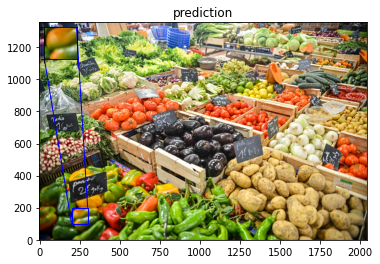

Epoch 22/300
60/60 - 877s - loss: 0.3075 - SSIMLoss: 0.3075 - val_loss: 0.3080 - val_SSIMLoss: 0.3080
Mean PSNR for epoch: 5.18
Epoch 23/300
60/60 - 875s - loss: 0.3068 - SSIMLoss: 0.3068 - val_loss: 0.3075 - val_SSIMLoss: 0.3075
Mean PSNR for epoch: 5.12
Epoch 24/300
60/60 - 870s - loss: 0.3069 - SSIMLoss: 0.3069 - val_loss: 0.3095 - val_SSIMLoss: 0.3095
Mean PSNR for epoch: 4.89
Epoch 25/300
60/60 - 875s - loss: 0.3058 - SSIMLoss: 0.3058 - val_loss: 0.3077 - val_SSIMLoss: 0.3077
Mean PSNR for epoch: 5.15
Epoch 26/300
60/60 - 874s - loss: 0.3065 - SSIMLoss: 0.3065 - val_loss: 0.3080 - val_SSIMLoss: 0.3080
Mean PSNR for epoch: 5.07
Epoch 27/300
60/60 - 879s - loss: 0.3066 - SSIMLoss: 0.3066 - val_loss: 0.3071 - val_SSIMLoss: 0.3071
Mean PSNR for epoch: 4.96
Epoch 28/300
60/60 - 871s - loss: 0.3043 - SSIMLoss: 0.3043 - val_loss: 0.3058 - val_SSIMLoss: 0.3058
Mean PSNR for epoch: 4.98
Epoch 29/300
60/60 - 871s - loss: 0.3053 - SSIMLoss: 0.3053 - val_loss: 0.3119 - val_SSIMLoss: 0.3119
Me

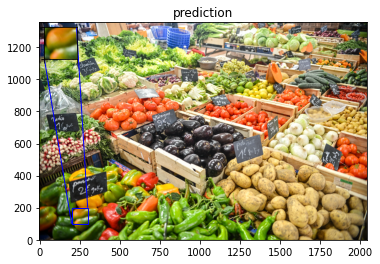

Epoch 42/300
60/60 - 868s - loss: 0.3013 - SSIMLoss: 0.3013 - val_loss: 0.3027 - val_SSIMLoss: 0.3027
Mean PSNR for epoch: 5.19
Epoch 43/300
60/60 - 866s - loss: 0.3001 - SSIMLoss: 0.3001 - val_loss: 0.3034 - val_SSIMLoss: 0.3034
Mean PSNR for epoch: 5.17
Epoch 44/300
60/60 - 865s - loss: 0.3014 - SSIMLoss: 0.3014 - val_loss: 0.3036 - val_SSIMLoss: 0.3036
Mean PSNR for epoch: 5.22
Epoch 45/300
60/60 - 867s - loss: 0.2997 - SSIMLoss: 0.2997 - val_loss: 0.3020 - val_SSIMLoss: 0.3020
Mean PSNR for epoch: 5.28
Epoch 46/300
60/60 - 865s - loss: 0.3008 - SSIMLoss: 0.3008 - val_loss: 0.3025 - val_SSIMLoss: 0.3025
Mean PSNR for epoch: 5.27
Epoch 47/300
60/60 - 872s - loss: 0.3008 - SSIMLoss: 0.3008 - val_loss: 0.3027 - val_SSIMLoss: 0.3027
Mean PSNR for epoch: 5.30
Epoch 48/300
60/60 - 868s - loss: 0.3011 - SSIMLoss: 0.3011 - val_loss: 0.3030 - val_SSIMLoss: 0.3030
Mean PSNR for epoch: 5.16
Epoch 49/300
60/60 - 866s - loss: 0.2991 - SSIMLoss: 0.2991 - val_loss: 0.3019 - val_SSIMLoss: 0.3019
Me

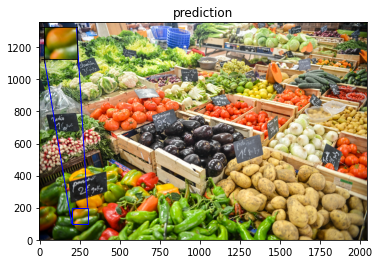

Epoch 62/300
60/60 - 866s - loss: 0.2971 - SSIMLoss: 0.2971 - val_loss: 0.3004 - val_SSIMLoss: 0.3004
Mean PSNR for epoch: 5.10
Epoch 63/300
60/60 - 869s - loss: 0.3022 - SSIMLoss: 0.3022 - val_loss: 0.3029 - val_SSIMLoss: 0.3029
Mean PSNR for epoch: 5.28
Epoch 64/300
60/60 - 866s - loss: 0.2975 - SSIMLoss: 0.2975 - val_loss: 0.3006 - val_SSIMLoss: 0.3006
Mean PSNR for epoch: 5.07
Epoch 65/300
60/60 - 868s - loss: 0.2979 - SSIMLoss: 0.2979 - val_loss: 0.3002 - val_SSIMLoss: 0.3002
Mean PSNR for epoch: 5.18
Epoch 66/300
60/60 - 867s - loss: 0.2964 - SSIMLoss: 0.2964 - val_loss: 0.2991 - val_SSIMLoss: 0.2991
Mean PSNR for epoch: 5.19
Epoch 67/300
60/60 - 868s - loss: 0.2960 - SSIMLoss: 0.2960 - val_loss: 0.2990 - val_SSIMLoss: 0.2990
Mean PSNR for epoch: 5.26
Epoch 68/300
60/60 - 873s - loss: 0.2968 - SSIMLoss: 0.2968 - val_loss: 0.3021 - val_SSIMLoss: 0.3021
Mean PSNR for epoch: 5.24
Epoch 69/300
60/60 - 871s - loss: 0.2970 - SSIMLoss: 0.2970 - val_loss: 0.3010 - val_SSIMLoss: 0.3010
Me

In [ ]:
epochs = 300

#def SSIMLoss(y_true, y_pred):
#  return 1 - tf.image.ssim(y_true, y_pred, 1)

def SSIMLoss(y_true, y_pred):
  return tf.reduce_mean(1 - tf.image.ssim(y_true, y_pred, 1))

model.compile(
    optimizer=optimizer, loss=SSIMLoss, metrics = [SSIMLoss]
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [1]:
#Testing th model.

total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

NameError: ignored